In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MaxAbsScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN
from sklearn import metrics

from datetime import datetime
import operator
import re

%matplotlib inline

In [2]:
PATH_TO_DATA = './../data/kaggle_receipts/'

In [3]:
train_df = pd.read_csv(PATH_TO_DATA + 'train.csv')
train_checks_df = pd.read_csv(PATH_TO_DATA + 'train_checks.csv')
train_full_df = pd.merge(train_df, train_checks_df, on='check_id')

test_df = pd.read_csv(PATH_TO_DATA + 'test.csv')
test_checks_df = pd.read_csv(PATH_TO_DATA + 'test_checks.csv')
test_full_df = pd.merge(test_df, test_checks_df, on='check_id')

In [4]:
name_replacers = [
    ('.', ' '),
    ('/', ' '),
    (',', ' '),
    ('*', ''),
    ('=', ''),
    ('k', 'к'),
    ('h', 'н'),
]

In [5]:
def contain_digits(name):
    digits_list = [str(i) for i in range(10)]
    for symbol in name:
        if symbol in digits_list:
            return True
    return False

def name_processing(name):
    result = name
    
    result = result.lower()
    for replacer in name_replacers:
        result = result.replace(*replacer)
        
    #result = ' '.join([token for token in result.split() if not token.isdigit()])
    result = ' '.join([token for token in result.split() if (not contain_digits(token)) and (len(token) > 2)])
    
    result = result.strip()
    return result

train_name_processed = train_full_df['name'].astype('str').apply(name_processing)

In [6]:
count_vectorizer = CountVectorizer(ngram_range=(1,2), max_features=10000)
train_name_cv = count_vectorizer.fit_transform(train_name_processed)

In [7]:
%%time

reverse_cv_vocabulary = {v: k for (k, v) in count_vectorizer.vocabulary_.items()}
frequency_vocabulary = {reverse_cv_vocabulary[col]: np.sum(train_name_cv[:, col]) for col in range(train_name_cv.shape[1])}

Wall time: 5.93 s


In [8]:
print(sorted(frequency_vocabulary.items(), key=operator.itemgetter(1), reverse=True)[0:50])

[('пакет', 606), ('вес', 504), ('хлеб', 351), ('сыр', 328), ('цена', 299), ('молоко', 297), ('для', 290), ('майка', 260), ('мол', 222), ('свеж', 218), ('охл', 214), ('лента', 189), ('напиток', 184), ('вода', 183), ('белый', 169), ('масло', 159), ('фас', 159), ('свеж цена', 157), ('бананы', 156), ('пиво', 153), ('яйцо', 152), ('паст', 151), ('батон', 149), ('сметана', 146), ('шок', 146), ('йогурт', 145), ('пакет майка', 143), ('творог', 142), ('корм', 140), ('яблоки', 138), ('пит', 136), ('шоколад', 135), ('салат', 132), ('пэт', 123), ('пюре', 122), ('газ', 121), ('дней', 120), ('красный', 120), ('филе', 120), ('яблоко', 119), ('лук', 114), ('печенье', 112), ('сок', 110), ('чипсы', 110), ('кефир', 105), ('пак', 105), ('картофель', 102), ('кофе', 100), ('томаты', 99), ('чай', 98)]


### by category

In [9]:
train_full_df['name'].fillna('', inplace=True)

top_count = 25

for category in np.unique(train_full_df['category']):
    #train_name_by_category = train_full_df[train_full_df['category'] == category]['name']
    train_name_by_category = train_full_df[train_full_df['category'] == category]['name'].apply(name_processing)
    
    count_vectorizer = CountVectorizer()
    train_name_by_category = count_vectorizer.fit_transform(train_name_by_category)
    
    reverse_cv_vocabulary = {v: k for (k, v) in count_vectorizer.vocabulary_.items()}
    frequency_vocabulary = {reverse_cv_vocabulary[col]: np.sum(train_name_by_category[:, col]) for col in range(train_name_by_category.shape[1])}
    
    print('TOP-{} words for category={}'.format(top_count, category))
    print(sorted(frequency_vocabulary.items(), key=operator.itemgetter(1), reverse=True)[:top_count])
    print()

TOP-25 words for category=Алкоголь
[('пиво', 153), ('светлое', 43), ('водка', 39), ('вино', 35), ('нап', 27), ('напиток', 23), ('пив', 21), ('балтика', 19), ('пивной', 15), ('пэт', 14), ('алк', 9), ('вин', 9), ('жигулевское', 9), ('сидр', 9), ('виски', 8), ('игр', 8), ('коньяк', 8), ('настойка', 8), ('бел', 7), ('кozel', 7), ('люкс', 7), ('медведь', 7), ('паст', 7), ('пастер', 7), ('свет', 7)]

TOP-25 words for category=Бакалея
[('сахар', 86), ('майонез', 65), ('крупа', 57), ('соус', 56), ('рис', 55), ('масло', 53), ('макароны', 52), ('лапша', 42), ('мак', 42), ('пак', 42), ('песок', 36), ('хлопья', 36), ('изд', 33), ('приправа', 33), ('мука', 32), ('провансаль', 31), ('maкfa', 27), ('экстра', 26), ('кетчуп', 25), ('слобода', 25), ('фас', 24), ('maggi', 23), ('раф', 22), ('тенд', 22), ('увелка', 22)]

TOP-25 words for category=Гастрономия
[('сыр', 288), ('колбаса', 90), ('сосиски', 63), ('вес', 59), ('колб', 46), ('мясн', 39), ('вар', 34), ('икра', 27), ('российский', 23), ('гост', 22)

TOP-25 words for category=Услуги
[('карта', 18), ('лояльности', 12), ('тариф', 9), ('приход', 8), ('сумма', 8), ('доставка', 6), ('платеж', 6), ('полный', 6), ('ком', 5), ('мтс', 5), ('спорт', 5), ('услуги', 5), ('бланк', 4), ('водоканал', 4), ('игр', 4), ('ооо', 4), ('разовый', 4), ('тел', 4), ('телеграммы', 4), ('фишка', 4), ('smart', 3), ('выдача', 3), ('идентификация', 3), ('купон', 3), ('мегафон', 3)]

TOP-25 words for category=Хлеб
[('хлеб', 335), ('батон', 147), ('нар', 75), ('нарезной', 68), ('нарезка', 38), ('хлебцы', 34), ('багет', 32), ('лаваш', 27), ('нарез', 25), ('пшеничный', 25), ('белый', 24), ('упак', 23), ('дарницкий', 19), ('булочка', 17), ('дом', 17), ('армянский', 16), ('сыром', 15), ('бородинский', 14), ('каравай', 14), ('форм', 14), ('вес', 11), ('столичный', 11), ('формовой', 11), ('хлебный', 11), ('домашний', 10)]

TOP-25 words for category=Чай и сладкое
[('шоколад', 126), ('шок', 113), ('печенье', 110), ('чай', 88), ('кофе', 73), ('конфеты', 67), ('мол', 60), 

In [10]:
top_words_count = 100

top_words_all_categories = set()

for category in np.unique(train_full_df['category']):
    
    train_name_by_category = train_full_df[train_full_df['category'] == category]['name'].apply(name_processing)
    
    count_vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=top_words_count * 10)
    train_name_by_category = count_vectorizer.fit_transform(train_name_by_category)
    
    reverse_cv_vocabulary = {v: k for (k, v) in count_vectorizer.vocabulary_.items()}
    sums_for_feature = np.sum(train_name_by_category, axis=0)
    frequency_vocabulary = {reverse_cv_vocabulary[col]: sums_for_feature[0, col] for col in range(sums_for_feature.shape[1])}
    
    top_words = {word[0] for word in sorted(frequency_vocabulary.items(), key=lambda x: x[1], reverse=True)[:top_words_count]}
    
    top_words_all_categories = top_words_all_categories | top_words
    
print('top words for {} categories size: {} '.format(len(np.unique(train_full_df['category'])), 
                                                     len(top_words_all_categories)))

top words for 25 categories size: 2115 


### clustering, PCA

In [48]:
train_name = train_full_df['name'].apply(name_processing)
test_name = test_full_df['name'].apply(name_processing)

category_labeler = LabelEncoder()
train_category = category_labeler.fit_transform(train_full_df['category'])

In [28]:
count_vectorizer_topwords = CountVectorizer(vocabulary=top_words_all_categories)

count_vectorizer_topwords.fit(train_name)

train_name_cvect_tw = count_vectorizer_topwords.transform(train_name)
test_name_cvect_tw = count_vectorizer_topwords.transform(test_name)

max_abs_scaler = MaxAbsScaler()
max_abs_scaler.fit(train_name_cvect_tw)

train_name_cvect_tw = max_abs_scaler.transform(train_name_cvect_tw)
test_name_cvect_tw = max_abs_scaler.transform(test_name_cvect_tw)

In [54]:
pca_2comp = PCA(n_components=2, random_state=14)
X_pca_2comp = pca_2comp.fit_transform(train_name_cvect_tw.todense())

pca_3comp = PCA(n_components=3, random_state=14)
X_pca_3comp = pca_3comp.fit_transform(train_name_cvect_tw.todense())

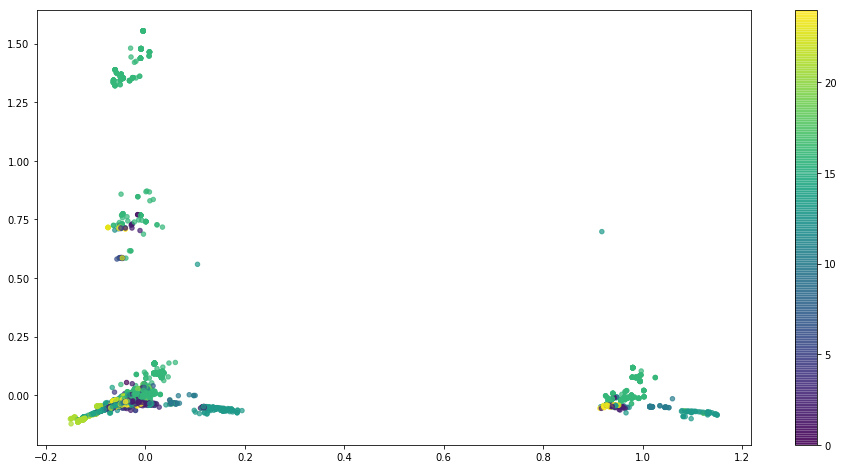

In [53]:
plt.figure(figsize=(16, 8))
plt.scatter(X_pca_2comp[:, 0], X_pca_2comp[:, 1], c=train_category, s=20, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.show()

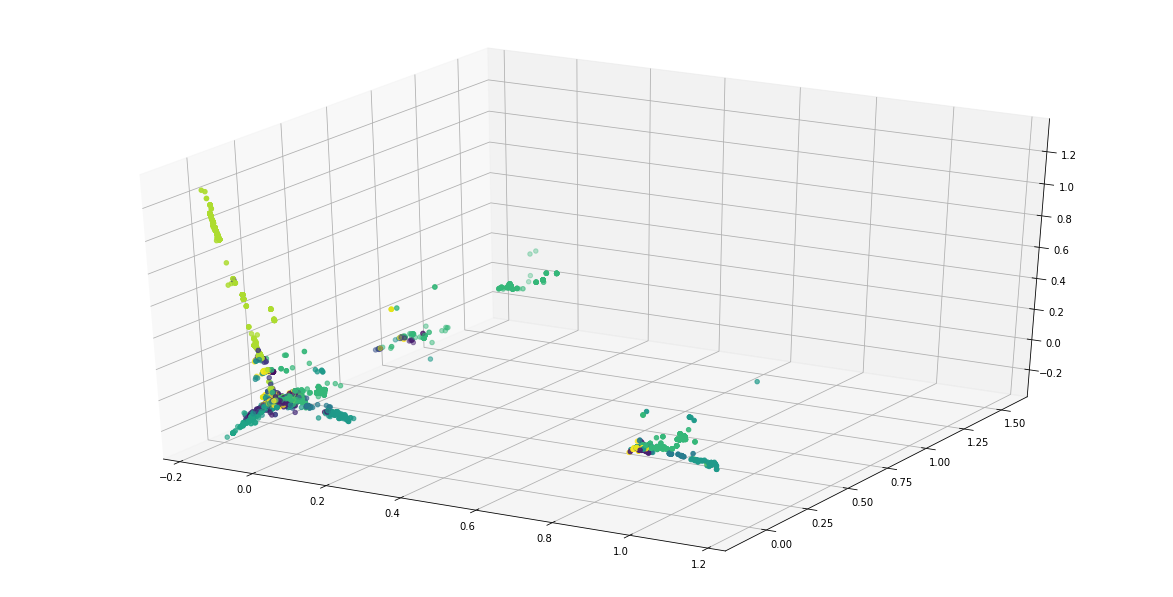

In [65]:
fig = plt.figure(figsize=(16, 8))
ax = Axes3D(fig)

ax.scatter(X_pca_3comp[:, 0], X_pca_3comp[:, 1], X_pca_3comp[:, 2], c=train_category)
#plt.colorbar()
plt.show()

In [85]:
n_classes = len(np.unique(train_category))

In [86]:
%%time

kmeans = KMeans(n_clusters=n_classes, n_init=100, random_state=14)
kmeans.fit(train_name_cvect_tw)

Wall time: 21.8 s


In [87]:
%%time

ac = AgglomerativeClustering(n_clusters=n_classes)
ac.fit(train_name_cvect_tw.toarray())

Wall time: 3min


In [88]:
%%time

sc = SpectralClustering(n_clusters=n_classes)
sc.fit(train_name_cvect_tw)

Wall time: 45.2 s


In [89]:
%%time

dbs = DBSCAN()
dbs.fit(train_name_cvect_tw)

Wall time: 8.22 s


In [90]:
print('KMeans:', metrics.adjusted_rand_score(train_category, kmeans.labels_))
print('AgglomerativeClustering:', metrics.adjusted_rand_score(train_category, ac.labels_))
print('SpectralClustering:', metrics.adjusted_rand_score(train_category, sc.labels_))
print('DBSCAN:', metrics.adjusted_rand_score(train_category, dbs.labels_))

KMeans: 0.017042226107067213
AgglomerativeClustering: 0.01765570414836086
SpectralClustering: 0.018815852454171722
DBSCAN: -0.012259758497748626


### datetime

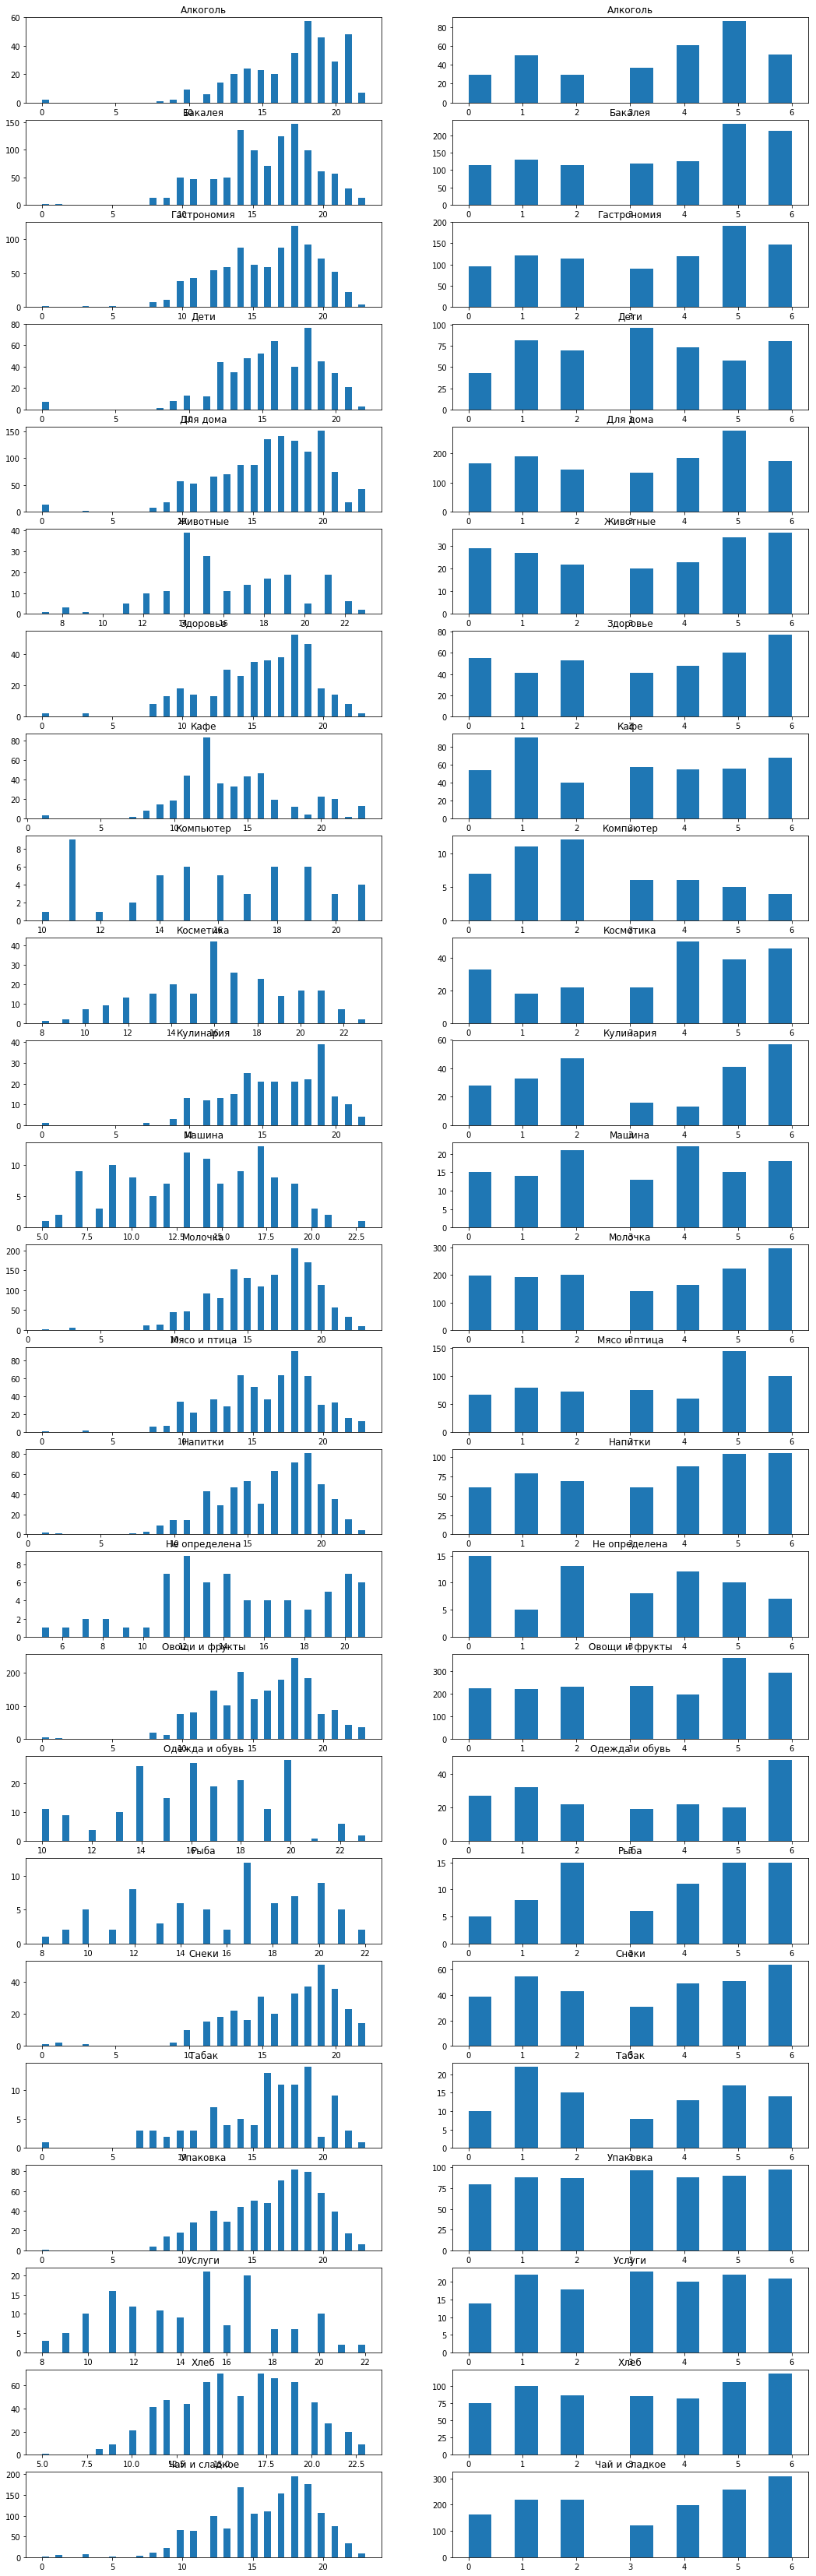

In [115]:
plt.figure(figsize=(18, 60))

categories = train_full_df['category']

for idx, category in enumerate(np.unique(categories)):
    
    train_dt_by_category = train_full_df[train_full_df['category'] == category]['datetime'].apply(pd.to_datetime)
    
    train_hour_by_category = train_dt_by_category.apply(lambda dt: dt.hour)
    train_dayofweek_by_category = train_dt_by_category.apply(lambda dt: dt.dayofweek)
    
    plt.subplot(len(np.unique(categories)), 2, 2 * idx + 1)
    plt.title(category)
    plt.hist(train_hour_by_category, bins=48)
    
    plt.subplot(len(np.unique(categories)), 2, 2 * idx + 2)
    plt.title(category)
    plt.hist(train_dayofweek_by_category, bins=14)